<a href="https://colab.research.google.com/github/DSGPproject/DSGP_model/blob/Esandu/ObjectDetection_transferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf

import tensorflow.keras as tfk
import tensorflow.keras.layers as tfl
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer("https://www.kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/101-classification/versions/2", input_shape=IMAGE_SHAPE+(3,))
])

In [3]:
# Load pre-trained ResNet model
resnet_model = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


94668760/94668760 [==============================] - 1s 0us/step


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
# Define image shape
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
IMAGE_SIZE = 224

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/objectdetection",
    seed=123,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

class_names = dataset.class_names
class_names


Found 883 files belonging to 1 classes.


['onlyLeafs']

In [7]:
# Create new model with ResNet base and additional classification layers
model = tf.keras.Sequential([
    resnet_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

In [8]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    remaining_ds = ds.skip(train_size)
    val_ds = remaining_ds.take(val_size)
    test_ds = remaining_ds.skip(val_size)

    return train_ds, val_ds, test_ds


In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
])

In [13]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
# Training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/20
22/22 [==============================] - 696s 20s/step - loss: 0.0470 - accuracy: 0.9711 - val_loss: 3.2744e-37 - val_accuracy: 1.0000
Epoch 2/20
22/22 [==============================] - 399s 18s/step - loss: 4.2227e-06 - accuracy: 1.0000 - val_loss: 2.9563e-23 - val_accuracy: 1.0000
Epoch 3/20
22/22 [==============================] - 400s 18s/step - loss: 1.5231e-06 - accuracy: 1.0000 - val_loss: 1.1411e-16 - val_accuracy: 1.0000
Epoch 4/20
22/22 [==============================] - 401s 18s/step - loss: 1.0372e-06 - accuracy: 1.0000 - val_loss: 5.2152e-11 - val_accuracy: 1.0000
Epoch 5/20
22/22 [==============================] - 401s 18s/step - loss: 2.0316e-06 - accuracy: 1.0000 - val_loss: 1.0906e-08 - val_accuracy: 1.0000
Epoch 6/20
22/22 [==============================] - 399s 18s/step - loss: 9.6505e-07 - accuracy: 1.0000 - val_loss: 9.5907e-09 - val_accuracy: 1.0000
Epoch 7/20
22/22 [==============================] - 399s 18s/step - loss: 9.0932e-07 - accuracy: 1.0000 

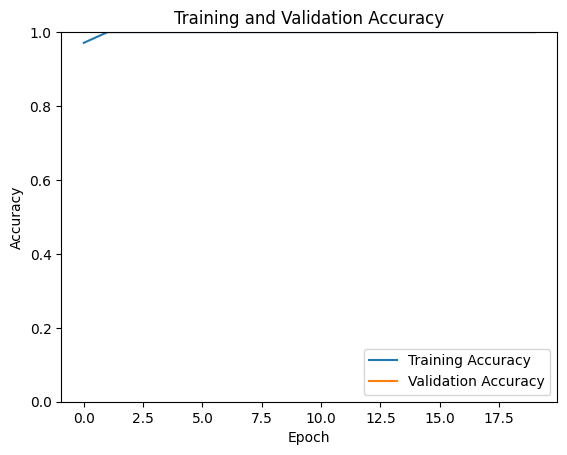

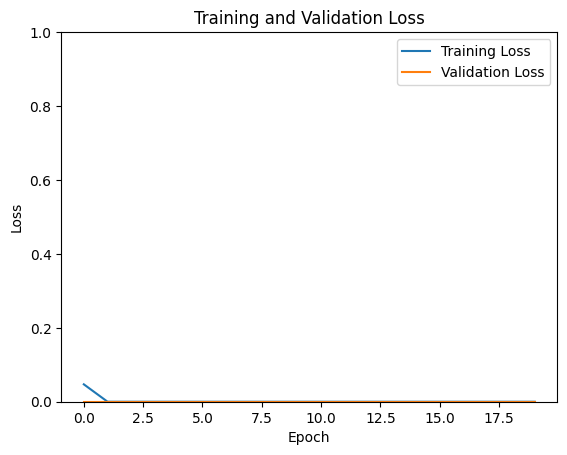

In [15]:
# Draw training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

# Draw training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
import os
from keras.models import load_model

# Replace 'model' with the name of your model
model_name = 'final object detection '

# Path to your Google Drive
drive_path = "/content/drive/MyDrive/colab_NoteBooks"

# Full path for saving the model
save_path = os.path.join(drive_path, model_name)

# Save the model
model.save(save_path)

In [17]:
# Save the model in h5 format
model.save("/content/drive/MyDrive/dataset/leaf_detection_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
